# FrozenLake-v0

In [1]:
%matplotlib inline

In [2]:
#! pip install protobuf

In [5]:
import numpy as np
import gym
# from api_key import api_key
import matplotlib.pyplot as plt
# import tensorflow as tf

Walking through and understanding code of : https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0#.7cwz7def1

In [6]:
env = gym.make('FrozenLake-v0')
obs = env.reset()
obs

env.render()

[2020-07-02 14:02:14,445] Making new env: FrozenLake-v0


SFFF
FHFH
FFFH
HFFG



/Users/andrew.patterson/Library/Caches/pypoetry/virtualenvs/openai-rXQ_zgIa-py3.7/lib/python3.7/site-packages/gym/envs/registration.py:18: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


## Completely random - how many 

In [8]:
reward_list = []

for a in range(2000):
    curr_state = env.reset()
    for t in range(100):

        ## Take a random action
        action = env.action_space.sample()

        ## take steps
        new_state, reward, done, info = env.step(action)
        
        if done:
            reward_list.append(reward)
            break
        
        # current step for next iteration
        curr_state = new_state
    
print('Final reward: ', sum(reward_list)/len(reward_list))

Final reward:  0.0105


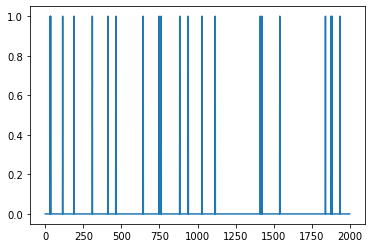

In [9]:
plt.plot(reward_list)

Doesnt really have a pattern of learning - It needs some optimisation

## Using Q-table learning

$$ {\displaystyle Q(s_{t},a_{t})\leftarrow \underbrace {Q(s_{t},a_{t})} _{\rm {old~value}}+\underbrace {\alpha } _{\rm {learning~rate}}\cdot \left(\overbrace {\underbrace {r_{t+1}} _{\rm {reward}}+\underbrace {\gamma } _{\rm {discount~factor}}\cdot \underbrace {\max _{a}Q(s_{t+1},a)} _{\rm {estimate~of~optimal~future~value}}} ^{\rm {learned~value}}-\underbrace {Q(s_{t},a_{t})} _{\rm {old~value}}\right)} $$

In [10]:
##Formalise the functions for each update and next action
def update_q(q,curr_state,new_state,action,reward,learning_rate,discount_factor):
    
    learned_value = reward + discount_factor*np.max(q[new_state,:])
    #q[curr_state,action] = q[curr_state,action] + learning_rate*(learned_value-q[curr_state,action])
    
    q[curr_state,action] = q[curr_state,action] + learning_rate*(learned_value - q[curr_state,action])

    return q

def select_action(q,curr_state,rand_scale):
    return np.argmax(q[curr_state,:] + np.random.randn(1,env.action_space.n)*rand_scale)

In [12]:
#env.monitor.start('/tmp/FrozenLake-v0',force=True)

Q = np.zeros([env.observation_space.n,env.action_space.n])

discount_factor = 0.99
learning_rate = 0.8

reward_list = []

episodes = 2000

for a in range(episodes):
    curr_state = env.reset()
    full_reward = 0
    for t in range(100):

        ## Take a random action
        rand_scale = (1./(a+1))
        action = select_action(Q,curr_state,rand_scale)
        
        ## take steps
        new_state, reward, done, info = env.step(action)
        
        ##Update Q based on steps
        full_reward += reward
        #learning_rate = 1.-(1./(a+1))
        Q = update_q(Q,curr_state,new_state,action,reward,learning_rate,discount_factor)
        
        if done:
            reward_list.append(full_reward)
            break
        
        # current step for next iteration
        curr_state = new_state
    
print('Final reward: ', sum(reward_list)/len(reward_list))

#env.monitor.close()
#gym.upload('/tmp/FrozenLake-v0',api_key=api_key)

Final reward:  0.5923997917751171


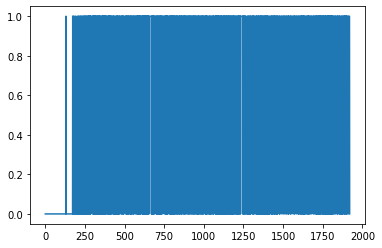

In [13]:
plt.plot(reward_list)

### What about a neural network - no hidden layers

In [14]:
tf.reset_default_graph()

#These lines establish the feed-forward part of the network used to choose actions
inputs1 = tf.placeholder(shape=[1,16],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16,4],0,0.01))
Qout = tf.matmul(inputs1,W)
predict = tf.argmax(Qout,1)

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

NameError: name 'tf' is not defined

In [12]:
init = tf.global_variables_initializer()

# Set learning parameters
y = .99
e = 0.1
num_episodes = 2000
#create lists to contain total rewards and steps per episode
jList = []
rList = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):

        #Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0

        #The Q-Network
        while j < 99:
            j+=1
            
            #Choose an action by greedily (with e chance of random action) from the Q-network
            a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(16)[s:s+1]})
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()

            #Get new state and reward from environment
            s1,r,d,_ = env.step(a[0])

            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout,feed_dict={inputs1:np.identity(16)[s1:s1+1]})

            #Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1

            #Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,W],feed_dict={inputs1:np.identity(16)[s:s+1],nextQ:targetQ})
            rAll += r
            s = s1

            if d == True:
                #Reduce chance of random action as we train the model.
                e = 1./((i/50) + 10)
                break

        jList.append(j)
        rList.append(rAll)

print "Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%"

Percent of succesful episodes: 0.054%


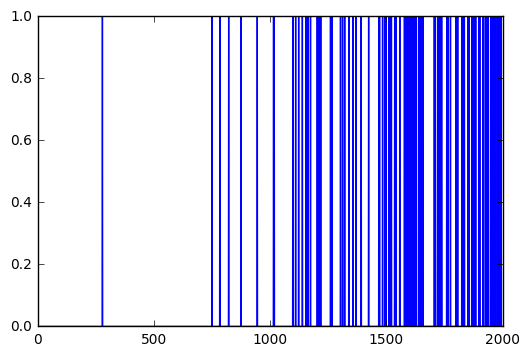

In [13]:
plt.plot(rList)